## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
import tensorflow as tf
import keras.backend as K

# Loss function 定義需要兩層
def combined_loss(gamma=2., alpha=4., ce_weights=0.7, fl_weights=0.3):
    gamma = float(gamma)
    alpha = float(alpha)
    def ce_fl_loss(y_true, y_pred):
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        
        ce_loss = keras.losses.categorical_crossentropy(y_true, y_pred)
        return (ce_weights*ce_loss) + (fl_weights*tf.reduce_mean(reduced_fl))
    return ce_fl_loss

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [8]:
import itertools
results = {}

for ce_w in ce_weights_list:
    print(f"Cross entropy loss weight: {ce_w}")
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss=combined_loss(ce_weights=ce_w, fl_weights=1.-ce_w), 
                  metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = (f"Cross entropy loss weight: {ce_w}")
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Cross entropy loss weight: 0.0

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 hidden_layer3 (Dense)       

Epoch 1/25



49/49 [==============================] - 2s 27ms/step - loss: 5.1593 - accuracy: 0.3816 - val_loss: 9.2391 - val_accuracy: 0.2032
Epoch 2/25
49/49 [==============================] - 1s 22ms/step - loss: 4.0201 - accuracy: 0.4681 - val_loss: 5.5936 - val_accuracy: 0.3196
Epoch 3/25
49/49 [==============================] - 1s 20ms/step - loss: 3.6618 - accuracy: 0.5023 - val_loss: 4.4727 - val_accuracy: 0.4225
Epoch 4/25
49/49 [==============================] - 1s 24ms/step - loss: 3.4047 - accuracy: 0.5309 - val_loss: 4.4970 - val_accuracy: 0.4093
Epoch 5/25
49/49 [==============================] - 1s 21ms/step - loss: 3.1951 - accuracy: 0.5506 - val_loss: 4.0533 - val_accuracy: 0.4665
Epoch 6/25
49/49 [==============================] - 1s 21ms/step - loss: 3.0066 - accuracy: 0.5717 - val_loss: 4.4195 - val_accuracy: 0.4249
Epoch 7/25
49/49 [==============================] - 1s 20ms/step - loss: 2.8259 - accuracy: 0.5892 - val_loss: 4.2021 - val_accuracy: 0.4497
Epoch 8/25
49/49 [======

Epoch 1/25
49/49 [==============================] - 2s 25ms/step - loss: 4.1629 - accuracy: 0.3788 - val_loss: 7.3813 - val_accuracy: 0.1572
Epoch 2/25
49/49 [==============================] - 1s 21ms/step - loss: 3.2713 - accuracy: 0.4688 - val_loss: 4.4300 - val_accuracy: 0.3182
Epoch 3/25
49/49 [==============================] - 1s 21ms/step - loss: 2.9929 - accuracy: 0.5042 - val_loss: 3.7700 - val_accuracy: 0.3986
Epoch 4/25
49/49 [==============================] - 1s 21ms/step - loss: 2.7873 - accuracy: 0.5327 - val_loss: 3.6975 - val_accuracy: 0.4005
Epoch 5/25
49/49 [==============================] - 1s 21ms/step - loss: 2.6440 - accuracy: 0.5510 - val_loss: 4.1760 - val_accuracy: 0.3501
Epoch 6/25
49/49 [==============================] - 1s 22ms/step - loss: 2.4930 - accuracy: 0.5697 - val_loss: 3.5474 - val_accuracy: 0.4350
Epoch 7/25
49/49 [==============================] - 1s 21ms/step - loss: 2.3455 - accuracy: 0.5893 - val_loss: 3.5130 - val_accuracy: 0.4328
Epoch 8/25
49

Epoch 1/25
49/49 [==============================] - 2s 25ms/step - loss: 3.4290 - accuracy: 0.3867 - val_loss: 4.2095 - val_accuracy: 0.2425
Epoch 2/25
49/49 [==============================] - 1s 21ms/step - loss: 2.7287 - accuracy: 0.4789 - val_loss: 3.5494 - val_accuracy: 0.3316
Epoch 3/25
49/49 [==============================] - 1s 21ms/step - loss: 2.4902 - accuracy: 0.5134 - val_loss: 3.1936 - val_accuracy: 0.3893
Epoch 4/25
49/49 [==============================] - 1s 20ms/step - loss: 2.3065 - accuracy: 0.5425 - val_loss: 3.1921 - val_accuracy: 0.3988
Epoch 5/25
49/49 [==============================] - 1s 20ms/step - loss: 2.1653 - accuracy: 0.5679 - val_loss: 2.7983 - val_accuracy: 0.4647
Epoch 6/25
49/49 [==============================] - 1s 20ms/step - loss: 2.0311 - accuracy: 0.5850 - val_loss: 3.0812 - val_accuracy: 0.4280
Epoch 7/25
49/49 [==============================] - 1s 21ms/step - loss: 1.9117 - accuracy: 0.6062 - val_loss: 3.1630 - val_accuracy: 0.4247
Epoch 8/25
49

Epoch 1/25
49/49 [==============================] - 2s 27ms/step - loss: 2.7999 - accuracy: 0.3847 - val_loss: 3.6590 - val_accuracy: 0.2225
Epoch 2/25
49/49 [==============================] - 1s 22ms/step - loss: 2.2265 - accuracy: 0.4801 - val_loss: 2.8165 - val_accuracy: 0.3432
Epoch 3/25
49/49 [==============================] - 1s 21ms/step - loss: 2.0431 - accuracy: 0.5185 - val_loss: 2.4934 - val_accuracy: 0.4291
Epoch 4/25
49/49 [==============================] - 1s 20ms/step - loss: 1.9061 - accuracy: 0.5466 - val_loss: 2.3312 - val_accuracy: 0.4555
Epoch 5/25
49/49 [==============================] - 1s 20ms/step - loss: 1.7928 - accuracy: 0.5691 - val_loss: 2.3612 - val_accuracy: 0.4593
Epoch 6/25
49/49 [==============================] - 1s 21ms/step - loss: 1.6873 - accuracy: 0.5867 - val_loss: 2.3224 - val_accuracy: 0.4549
Epoch 7/25
49/49 [==============================] - 1s 20ms/step - loss: 1.5919 - accuracy: 0.6088 - val_loss: 2.4392 - val_accuracy: 0.4414
Epoch 8/25
49

Epoch 1/25
49/49 [==============================] - 3s 25ms/step - loss: 1.8450 - accuracy: 0.3675 - val_loss: 2.2588 - val_accuracy: 0.2147
Epoch 2/25
49/49 [==============================] - 1s 21ms/step - loss: 1.5046 - accuracy: 0.4693 - val_loss: 1.8314 - val_accuracy: 0.3251
Epoch 3/25
49/49 [==============================] - 1s 20ms/step - loss: 1.3930 - accuracy: 0.5083 - val_loss: 1.6975 - val_accuracy: 0.3775
Epoch 4/25
49/49 [==============================] - 1s 20ms/step - loss: 1.3136 - accuracy: 0.5370 - val_loss: 1.5642 - val_accuracy: 0.4421
Epoch 5/25
49/49 [==============================] - 1s 21ms/step - loss: 1.2451 - accuracy: 0.5615 - val_loss: 1.7288 - val_accuracy: 0.3812
Epoch 6/25
49/49 [==============================] - 1s 20ms/step - loss: 1.1839 - accuracy: 0.5838 - val_loss: 1.5793 - val_accuracy: 0.4293
Epoch 7/25
49/49 [==============================] - 1s 21ms/step - loss: 1.1216 - accuracy: 0.6049 - val_loss: 1.5798 - val_accuracy: 0.4352
Epoch 8/25
49

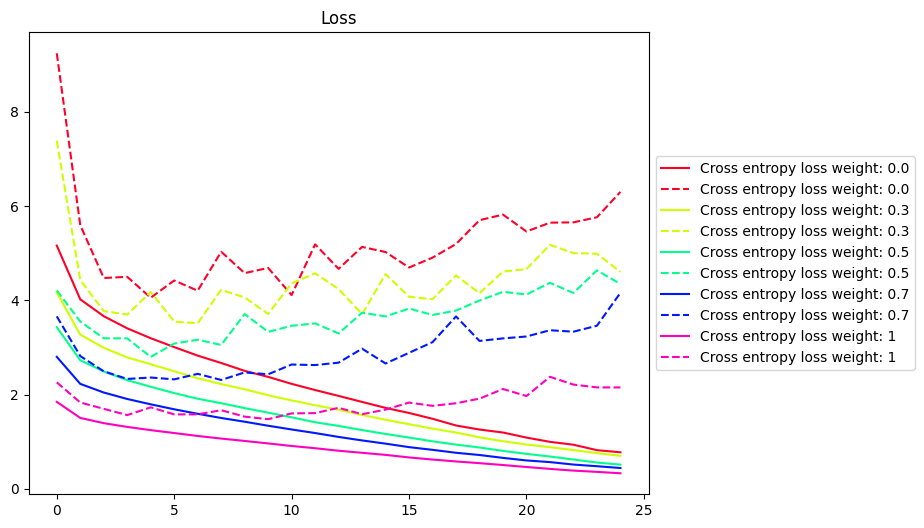

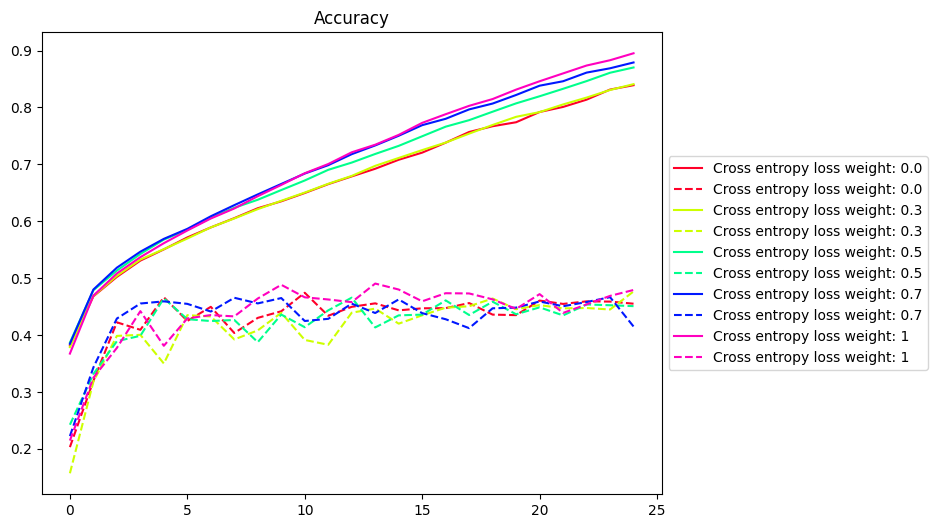

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

* Categorical crossentropy 比重越高, loss function 越小, 且 over-fitting 程度越小